<h1 align="center"><font color="yellow">Como usar o TensorBoard com o PyTorch</font></h1>

<font color="yellow">Data Scientist.: PhD.Eddy Giusepe Chirinos Isidro</font>

In [1]:
import torch
print(torch.__version__)


2.0.1+cu117


In [56]:
%load_ext watermark 
%watermark -v -p numpy,pandas,matplotlib,torch,tensorboard

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.13.2

numpy      : 1.24.3
pandas     : 2.0.1
matplotlib : 3.7.1
torch      : 2.0.1
tensorboard: 2.13.0



In [96]:
import os

# Definimos a variável de ambiente CUDA_VISIBLE_DEVICES como um valor inválido para a GPU ou seja CPU:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # "0" para usar GPU "-1" para CPU


In [97]:
import matplotlib.pyplot as plt
import numpy as np

import torch 
import torchvision
import torchvision.transforms as transforms 

import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 


import cv2
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F  
#from google.colab.patches import cv2_imshow



In [98]:
device = ("cuda" if torch.cuda.is_available() else "cpu")

In [99]:
device

'cpu'

In [115]:
from torch.utils.tensorboard import SummaryWriter

#writer = SummaryWriter("runs/eddy_mnist")
writer = SummaryWriter()


In [116]:
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])


train_set = datasets.FashionMNIST("data_MNIST/",
                                  download=True,
                                  train=True,
                                  transform=transform
                                 )

trainloader = torch.utils.data.DataLoader(train_set,
                                          batch_size=64,
                                          shuffle=True
                                         )

test_set = datasets.FashionMNIST("data_MNIST/",
                                  download=True,
                                  train=False,
                                  transform=transform
                                 )

testloader = torch.utils.data.DataLoader(test_set,
                                          batch_size=64,
                                          shuffle=True
                                         )


In [117]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data_MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [118]:
test_set

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data_MNIST/
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [119]:
testloader

In [120]:
train_data_size = len(train_set)
train_data_size

60000

In [121]:
test_data_size = len(test_set)
test_data_size

10000

In [122]:
classes = ("T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
           "Bag", "Ankle Boot")


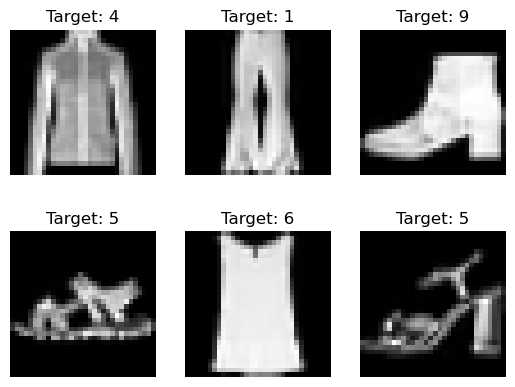

In [123]:
examples = iter(testloader)

data, targets = next(examples)


for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(data[i][0], cmap="gray")
    plt.title("Target: {}".format(targets[i]))
    plt.axis('off')
    

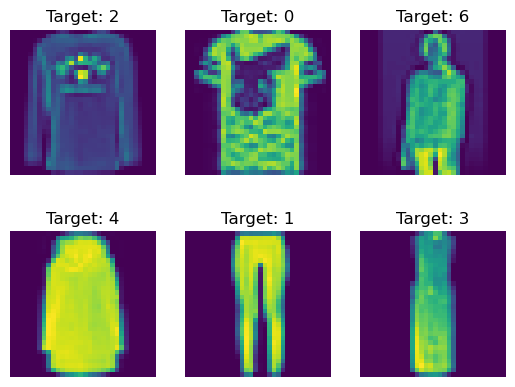

In [124]:
examples = iter(testloader)
data, targets = next(examples)

for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(data[i].permute(1, 2, 0))  # Exibindo a imagem (transpondo as dimensões)
    plt.title("Target: {}".format(targets[i]))
    plt.axis('off')

plt.show()


In [125]:
img_grid = torchvision.utils.make_grid(data)

writer.add_image("MNIST_imagens", img_grid)
writer.close()


Vamos para o Browser, na seguinte URL: [http://localhost:6006/](http://localhost:6006/)

In [126]:
class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()


        self.convolutional_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )


        self.linear_layer = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=10),
        )


    def forward(self, x):
        x = self.convolutional_layer(x)
        x = torch.flatten(x, 1)
        x = self.linear_layer(x)
        x = F.softmax(x, dim=1)
        return x
    
    

In [127]:
model = LeNet5().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

criterion = nn.CrossEntropyLoss()

In [128]:
# Podemos visualizar a nossa arquitetura de nossa Rede Neural, simplesmente chamando assim:
# Executando esta célula você já pode ir ao Browser e visualizar a sua Arquitetura de Rede Neural.

writer.add_graph(model, data)
writer.close()


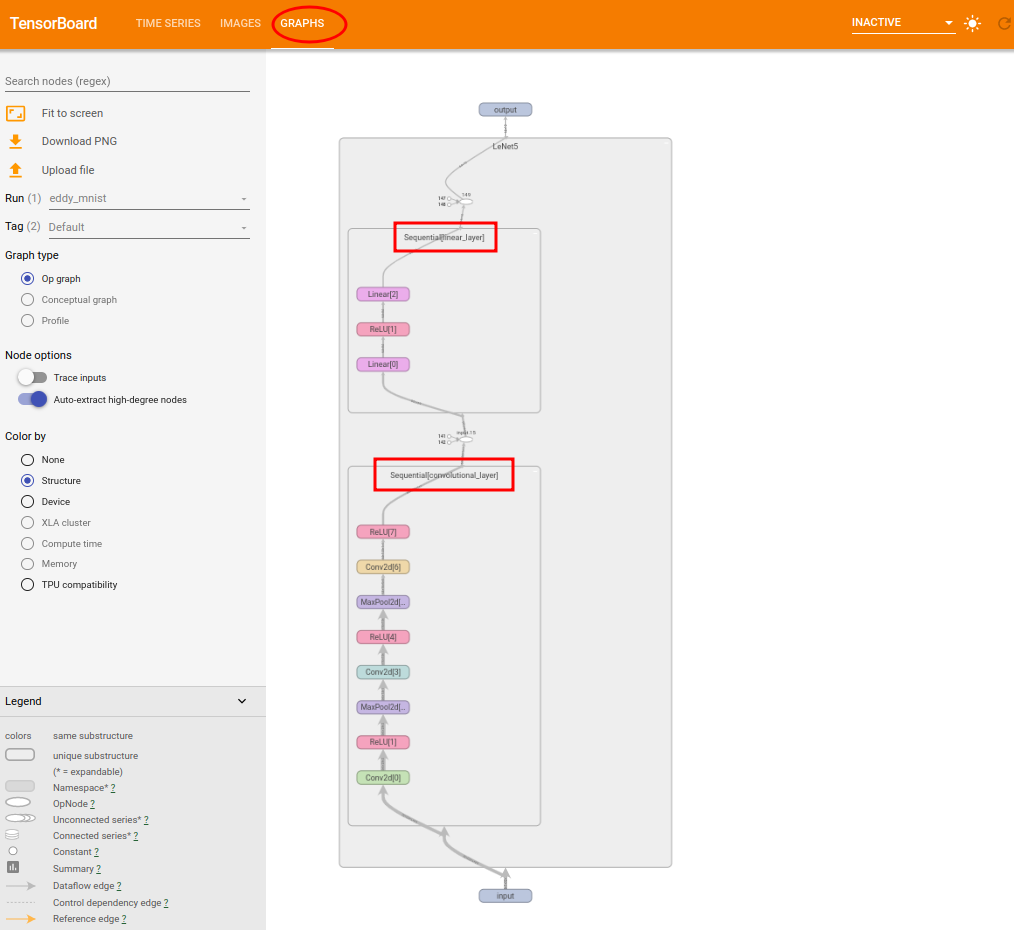

In [129]:
# Fazemos um Lopp sobre o Dataset várias vezes.
for epoch in range(5):
    total_train_loss = 0.0
    total_test_loss = 0.0

    print("Épocas: ", epoch)

    model.train()


    total = 0
    for idx, (image, label) in enumerate(trainloader):
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()


        total_train_loss += loss.item()
        pred = torch.nn.functional.softmax(pred, dim=1)


        for i, p in enumerate(pred):

            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1 



    total_train_acc = total / len(train_set)
    total_train_loss = total_train_loss / (idx + 1)



    total = 0
    model.eval()
    for idx, (image, label) in enumerate(testloader):
        image, label = image.to(device), label.to(device)

        pred = model(image)
        loss = criterion(pred, label)
        total_test_loss += loss.item()
        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1



    total_test_acc = total / len(test_set)
    total_test_loss = total_test_loss / (idx + 1)


    # A cada 2 épocas
    if epoch % 2 == 0: 
        writer.add_scalar('Loss/Training',
                          total_train_loss,
                          epoch)
    
        writer.add_scalar('Loss/Testing',
                          total_test_loss,
                          epoch)
    
        writer.add_scalar('Accuracy/Training',
                          total_train_acc,
                          epoch)
    
        writer.add_scalar('Accuracy/Testing',
                          total_test_acc,
                          epoch)

        writer.close()


        print("Épocas: ", epoch)



Épocas:  0
Épocas:  0
Épocas:  1
Épocas:  2
Épocas:  2
Épocas:  3
Épocas:  4
Épocas:  4
